# **Анализ модели обнаружения производственных дефектов YOLO  с использованием Class Activation Maps**

1. Подготовка для работы.

In [ ]:
!pip install -U git+https://github.com/Deci-AI/super-gradients@e0ccacf8868ffa1296fa4f8407c03d2bc227312c -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 74.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.9/913.9 kB 51.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40

In [ ]:
!pip install supervision -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/usr/local/lib/python3.11/dist-packages/super_gradients/training/pretrained_models.py"

with open(file_path, "r") as file:
    content = file.read()

content = content.replace("sghub.deci.ai", "sg-hub-nv.s3.amazonaws.com")

with open(file_path, "w") as file:
    file.write(content)

print(f"Modified {file_path}")



file_path = "/usr/local/lib/python3.11/dist-packages/super_gradients/training/utils/checkpoint_utils.py"

with open(file_path, "r") as file:
    content = file.read()

content = content.replace("sghub.deci.ai", "sg-hub-nv.s3.amazonaws.com")

with open(file_path, "w") as file:
    file.write(content)

print(f"Modified {file_path}")


Modified /usr/local/lib/python3.11/dist-packages/super_gradients/training/pretrained_models.py
Modified /usr/local/lib/python3.11/dist-packages/super_gradients/training/utils/checkpoint_utils.py


In [ ]:
#!unzip '/content/drive/MyDrive/data_science/xai_yolo/dataset.zip' -d '/content/drive/MyDrive/data_science/xai_yolo/dataset'

Archive:  /content/drive/MyDrive/data_science/xai_yolo/dataset.zip


# **Анализ модели. Построение pipeline**

In [ ]:
import numpy as np
import requests
import matplotlib.pyplot as plt
from torch.nn import functional as F

from PIL import Image
import cv2
from torchvision import transforms

from super_gradients.training import models
import torch
import os

import pandas as pd
from collections import Counter



The console stream is logged into /root/sg_logs/console.log


[2025-01-22 15:44:16] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2025-01-22 15:44:20] INFO - utils.py - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
[2025-01-22 15:44:30] INFO - env_sanity_check.py - Library check is not supported when super_gradients installed through "git+https://github.com/..." command


In [ ]:
class Hook():

    def __init__(self, m):
      self.hook = m.register_forward_hook(self.hook_func) #цепляемся за forward проход слоя m, переданного при инициализации

    def hook_func(self, module, input, output):
     # self.features = ((output.cpu()).data).numpy()
      self.features = output.detach().cpu().numpy()  #получаем output слоя и лепим в numpy массив

    def remove(self):
      self.hook.remove()

# **Постановка задачи**

**Цель проводимого анализа:** выяснить общую тенденцию — изменятся ли прогнозы модели, если в данные попадёт шум, имитирующий помехи сигнала.

**Примечания:**
- В качестве имитации помех выбран гауссовский шум
- При анализе опущены истинные метки и оцениваются только метки, спрогнозированные моделью на шумном и оригинальном изображении.

Как это работает для одного изображения:

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import random
import numpy as np
torch.manual_seed(42)
import random
random.seed(0)
import numpy as np
np.random.seed(0)


def add_gaussian_noise(image_tensor, mean=0.0, std=0.1):
    """Добавляет гауссовский шум к изображению."""
    noise = torch.normal(mean=mean, std=std, size=image_tensor.shape)
    noisy_image = image_tensor + noise
    return torch.clamp(noisy_image, 0.0, 1.0)

def add_salt_and_pepper_noise(image_tensor, prob=0.1):
    """Добавляет импульсный шум (salt-and-pepper) к изображению."""
    noisy_image = image_tensor.clone()
    num_salt = int(prob * image_tensor.numel() * 0.5)
    num_pepper = int(prob * image_tensor.numel() * 0.5)

    # Добавляем "соль" (белые пиксели)
    salt_indices = torch.randint(0, image_tensor.numel(), (num_salt,))
    noisy_image.view(-1)[salt_indices] = 1.0

    # Добавляем "перец" (черные пиксели)
    pepper_indices = torch.randint(0, image_tensor.numel(), (num_pepper,))
    noisy_image.view(-1)[pepper_indices] = 0.0

    return noisy_image

def add_dropout_noise(image_tensor, dropout_prob=0.3):
    """Добавляет шум с помощью случайных пропусков (Dropout)."""
    dropout_mask = torch.rand_like(image_tensor) > dropout_prob
    return image_tensor * dropout_mask.float()

def add_random_pixel_shift(image_tensor, shift_max=5):
    """Добавляет шум с помощью случайного сдвига пикселей."""
    shift_x = random.randint(-shift_max, shift_max)
    shift_y = random.randint(-shift_max, shift_max)

    # Сдвигаем изображение на случайное количество пикселей
    return torch.roll(image_tensor, shifts=(shift_x, shift_y), dims=(1, 2))

def add_random_scaling_noise(image_tensor, scale_range=(0.8, 1.2)):
    """Добавляет шум с использованием случайного масштабирования."""
    scale_factor = random.uniform(scale_range[0], scale_range[1])
    new_size = (int(image_tensor.shape[1] * scale_factor), int(image_tensor.shape[2] * scale_factor))
    scaled_image = torch.nn.functional.interpolate(image_tensor.unsqueeze(0), size=new_size, mode='bilinear', align_corners=False).squeeze(0)

    # Обрезаем изображение до исходного размера
    return torch.nn.functional.interpolate(scaled_image.unsqueeze(0), size=(image_tensor.shape[1], image_tensor.shape[2]), mode='bilinear', align_corners=False).squeeze(0)

def add_color_jitter(image_tensor, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
    """Добавляет цветовой шум (цветовое искажение) к изображению."""
    transform = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
    return transform(transforms.ToPILImage()(image_tensor))

def get_original_and_noisy_image(file, noise_type='gaussian'):

    # Препроцессинг оригинала
    img = Image.open(file)

    transform = transforms.Compose([transforms.Resize((640, 640)),
                                    transforms.ToTensor()])

    tensor = transform(img).unsqueeze(0)

    # Добавление шума в зависимости от выбранного типа
    if noise_type == 'gaussian':
        noisy_tensor_image = add_gaussian_noise(tensor)
    elif noise_type == 'salt_and_pepper':
        noisy_tensor_image = add_salt_and_pepper_noise(tensor)
    elif noise_type == 'dropout':
        noisy_tensor_image = add_dropout_noise(tensor)
    elif noise_type == 'pixel_shift':
        noisy_tensor_image = add_random_pixel_shift(tensor)
    elif noise_type == 'scaling':
        noisy_tensor_image = add_random_scaling_noise(tensor)
    elif noise_type == 'color_jitter':
        noisy_tensor_image = add_color_jitter(tensor[0])  # Для color jitter нужно работать с PIL-изображениями

    # Преобразование обратно в изображение
    to_pil = transforms.ToPILImage()
    noisy_image = to_pil(noisy_tensor_image[0]) if noise_type != 'color_jitter' else noisy_tensor_image

    return (img, tensor), (noisy_image, noisy_tensor_image)


In [ ]:
def get_map_and_prediction(model, image, image_tensor, conf, iou):

  final_layer = model.heads.head3.cls_convs._modules['0']._modules['seq']._modules['act'] # Активаиция головы 3 после RELU
  # слой для извлечения карт

  act_maps = Hook(final_layer)

  prediction = model.predict(image, conf=conf, iou=iou,fuse_model=False)
  act_maps.remove()

  CLASSES = ["adj", "int", "geo", "pro", "non"]
  prediction.class_names = CLASSES

  labels_predicted = prediction.prediction.labels

  return act_maps.features[0], labels_predicted


def process_image_predictions(image_name, original_preds, noisy_preds, diff_between_maps_mean, diff_between_maps_median):
    """
    Обрабатывает прогнозы модели для оригинального и шумного изображения.

    :param image_name: Имя изображения (строка)
    :param original_preds: Прогнозы модели для оригинального изображения (список или массив)
    :param noisy_preds: Прогнозы модели для изображения с шумом (список или массив)
    :return: pd.DataFrame с одной строкой
    """
    # Подсчёт меток для оригинального изображения
    original_counts = Counter(original_preds)
    noisy_counts = Counter(noisy_preds)

    # Создание строки данных
    data = {
        f"original_{i}": original_counts.get(i, 0) for i in range(5)
    }
    data.update({
        f"noisy_{i}": noisy_counts.get(i, 0) for i in range(5)
    })
    data.update({'abs_diff_between_act_mean' : diff_between_maps_mean,
                'abs_diff_between_act_median' : diff_between_maps_median })


    # Возвращаем строку как DataFrame
    return pd.DataFrame(data, index=[image_name.split('/')[-1]])

def get_figure(model, img_original, act_maps_original, img_noisy, act_maps_noisy, save=False, name=None, out_dir=None):

  weights_interested = model.heads.head3.cls_pred.weight[2, :].cpu().data.numpy() # извлечение весов

  cam_orig = weights_interested.reshape(256).dot(act_maps_original.reshape((256, 20*20)))
  cam_noisy = weights_interested.reshape(256).dot(act_maps_noisy.reshape((256, 20*20)))


  cam_orig = cam_orig.reshape((20,20))
  cam_tensor_orig = torch.from_numpy(cam_orig).float().unsqueeze(0).unsqueeze(0)  # Преобразовываем обратно в тензор
  interpol_orig = F.interpolate(cam_tensor_orig, (640, 640), mode="bilinear").squeeze(0).squeeze(0) # Интерполируем карту на изображение

  cam_noisy = cam_noisy.reshape((20,20))
  cam_tensor_noisy = torch.from_numpy(cam_noisy).float().unsqueeze(0).unsqueeze(0)  # Преобразовываем обратно в тензор
  interpol_noisy = F.interpolate(cam_tensor_noisy, (640, 640), mode="bilinear").squeeze(0).squeeze(0) # Интерполируем карту на изображение


  fig = plt.figure(figsize=(8,8))

  plt.subplot(221)
  plt.imshow(img_original.resize((640, 640)))
  plt.title('Original Image')

  plt.subplot(222)
  plt.imshow(img_noisy)
  plt.axis('off')
  plt.title('Noisy Image')

  plt.subplot(223)
  plt.imshow(img_original.resize((640, 640)))
  plt.axis('off')
  plt.imshow(interpol_orig, alpha=0.5, cmap='jet');
  plt.title('Original + CAM')


  plt.subplot(224)
  plt.imshow(img_noisy)
  plt.axis('off')
  plt.imshow(interpol_noisy, alpha=0.5, cmap='jet')
  plt.title('Noisy + CAM')

  if save:
    fig.savefig(out_dir+name)


In [ ]:
from super_gradients.common.object_names import Models

# Загрузка модели
model_project_classic = models.get(model_name='yolo_nas_s',
                            num_classes=5,
                            checkpoint_path='/content/drive/MyDrive/data_science/xai_yolo/surfacing-defects-service/weights/ckpt_best_4.pth')

model_project_classic.eval();

model_test = models.get(Models.YOLO_NAS_S, pretrained_weights="coco")

/usr/local/lib/python3.11/dist-packages/super_gradients/training/utils/checkpoint_utils.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_pa

В качестве вспомогательного инструмента для оценки влияния помех на обработку данных модели, выбраны Class Activation Maps. Построение такх карт проводится по формуле:

$$CAM_k = w^c_kA^k$$

где $A^k$ — карта активации модели для $k$-го класса на последнем сверточном слое (осуществляющем классификацию).

**Выбор слоя:**

Архитектуре моделей типа YOLO (You Only Look Once) включает в себя части `head` (головы) и `neck` (шеи).

1. Задача neck — это передача признаков, полученных из backbone (основной части сети, которая извлекает особенности из изображения), в head. В этой части модели происходит снижение размерности, объединение признаков и подготовка признаков для классификации и локализации. Основная цель neck — извлечение и обработка признаков на различных уровнях, чтобы дать более информативные входы для head.

2. Head выполняет основную задачу классификации объектов. Здесь происходят решения о том, какой объект присутствует на изображении (классификация), а также вычисление координат и размеров ограничивающих рамок (локализация).

Для построения карт активации проводился анализ голов модели, в силу того, что они вносят итоговый вклад в прогноз.  










**Примечание:**

Также важно отметить, что модель YOLO NAS S состоит из трёх голов. При анализе активаций на каждой, было выявлено, что:

- голова 1 отвечает за мелкие детали изображения (вплоть до пикселей);
- голова 2 извлекает признаки более сложные (кривые и простые детали);
- голова 3 извлекает более семантически сложные признаки;

Карты собирались с третьей головы, однако головы 1 и 2 имеют схожее поведение.


**Активации брались, связанные с классом дефектов geo — дефектов геометрии на шве (класс 2)**. Данный класс является наиболее важным с точки зрения бизнес-постановки.

In [ ]:
model_project_classic.heads.head3.cls_convs._modules['0'] #._modules['seq'][2] # слой для извлечения карт


Sequential(
  (0): ConvBNReLU(
    (seq): Sequential(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
  )
)

In [ ]:
torch.manual_seed(42)

path_to_img = '/content/drive/MyDrive/data_science/xai_yolo/dataset/5 (146).jpg'

(img_orig, tensor_orig), (img_noisy, tensor_noisy) = get_original_and_noisy_image(path_to_img, 'gaussian')

act_map_orig, labels_orig = get_map_and_prediction(model_project_classic, img_orig, tensor_orig, 0.1, 0.25)
act_map_noisy, labels_noisy = get_map_and_prediction(model_project_classic, img_noisy, tensor_noisy, 0.1, 0.25)

diff_median = np.median(np.abs(act_map_orig - act_map_noisy)).item()
diff_mean = np.abs(act_map_orig - act_map_noisy).mean().item()

df_row = process_image_predictions(path_to_img, labels_orig, labels_noisy, diff_mean, diff_median)

/usr/local/lib/python3.11/dist-packages/super_gradients/training/pipelines/pipelines.py:223: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with eval_mode(self.model), torch.no_grad(), torch.cuda.amp.autocast(enabled=self.fp16):
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [ ]:
print(f"Среднее различие активаций: {diff_mean}")
print(f"Медианное различие активаций: {diff_median}")
df_row

,original_0,original_1,original_2,original_3,original_4,noisy_0,noisy_1,noisy_2,noisy_3,noisy_4,abs_diff_between_act_mean,abs_diff_between_act_median
5 (146).jpg,18,9,10,2,1,0,5,2,0,0,0.89235,0.169307


Среднее различие активаций: 0.8923498392105103
Медианное различие активаций: 0.16930729150772095


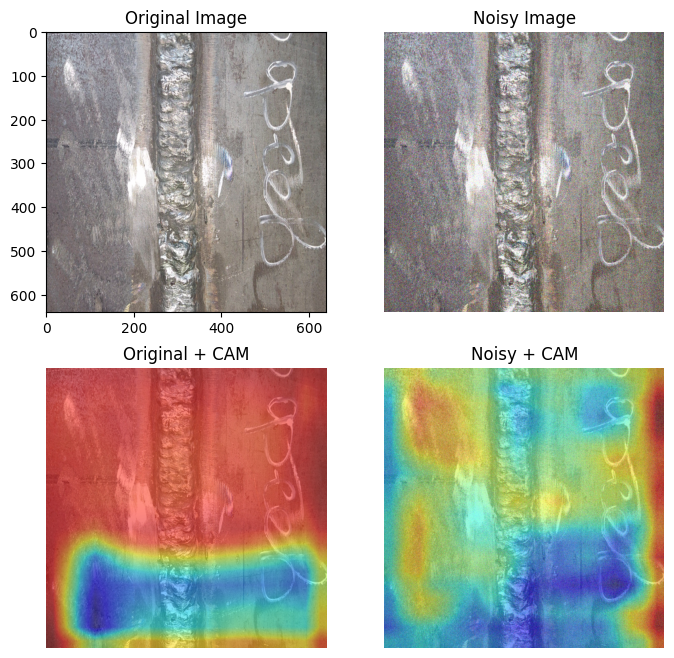

In [ ]:
get_figure(model_project_classic, img_orig, act_map_orig, img_noisy, act_map_noisy, save=False, name=None)

/usr/local/lib/python3.11/dist-packages/super_gradients/training/pipelines/pipelines.py:223: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with eval_mode(self.model), torch.no_grad(), torch.cuda.amp.autocast(enabled=self.fp16):
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


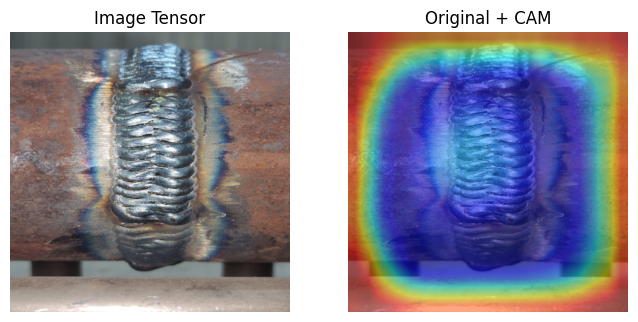

In [ ]:
path_to_img = '/content/drive/MyDrive/data_science/xai_yolo/dataset/8 (88).jpg'

img = Image.open(path_to_img)

transform = transform = transforms.Compose([transforms.Resize((640, 640)),
                                            transforms.ToTensor(),
                                            ])

tensor = transform(img).unsqueeze(0)

# CAM original
final_layer = model_project_classic.heads.head3.cls_convs._modules['0']._modules['seq']._modules['act']

act_maps_orig = Hook(final_layer)
results = model_project_classic(tensor)
act_maps_orig.remove()

prediction = model_project_classic.predict(img, conf=0.1, iou=0.25, fuse_model=False)
CLASSES = ["adj", "int", "geo", "pro", "non"]
prediction.class_names = CLASSES

labels_predicted_original = prediction.prediction.labels

weights_interested = model_project_classic.heads.head3.cls_pred.weight[2, :].cpu().data.numpy() # извлечение весов
cam = weights_interested.reshape(256).dot(act_maps_orig.features[0].reshape((256, 20*20)))
cam = cam.reshape((20,20))

cam_tensor = torch.from_numpy(cam).float().unsqueeze(0).unsqueeze(0)  # Преобразовываем обратно в тензор
interpol = F.interpolate(cam_tensor, (640, 640), mode="bilinear").squeeze(0).squeeze(0) # Интерполируем карту на изображение

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(tensor.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Image Tensor')


plt.subplot(222)
plt.imshow(tensor.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.imshow(interpol, alpha=0.5, cmap='jet');
plt.title('Original + CAM');

Text(0.5, 1.0, 'Noisy + CAM')

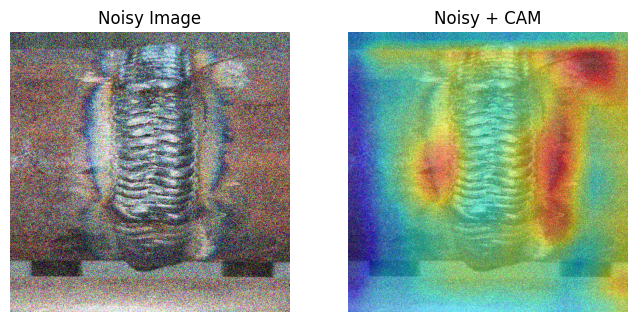

In [ ]:
# CAM noisy
noise = torch.normal(mean=0.0, std=0.3, size=tensor.shape)

# Добавление шума
noisy_tensor_image = torch.clamp(tensor + noise, 0, 1)  # Обрезка значений до диапазона [0, 1]

# Преобразование обратно в изображение
to_pil = transforms.ToPILImage()
noisy_image = to_pil(noisy_tensor_image[0])

#final_layer_noisy = model_project_classic.heads.head3.cls_convs._modules['0']._modules['seq']._modules['act']
act_maps_noisy = Hook(final_layer)

#results_noisy = model_project_classic(noisy_tensor_image)
prediction_noisy = model_project_classic.predict(noisy_image, conf=0.1, iou=0.25, fuse_model=False)
act_maps_noisy.remove()

CLASSES = ["adj", "int", "geo", "pro", "non"]
prediction_noisy.class_names = CLASSES

labels_predicted_noisy = prediction_noisy.prediction.labels

#weights_interested = model_project_classic.heads.head3.cls_pred.weight[2, :].cpu().data.numpy() # извлечение весов
cam = weights_interested.reshape(256).dot(act_maps_noisy.features[0].reshape((256, 20*20)))

cam = cam.reshape((20,20))

cam_tensor = torch.from_numpy(cam).float().unsqueeze(0).unsqueeze(0)  # Преобразовываем обратно в тензор
interpol = F.interpolate(cam_tensor, (640, 640), mode="bilinear").squeeze(0).squeeze(0) # Интерполируем карту на изображение


plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(noisy_image)
plt.axis('off')
plt.title('Noisy Image')


plt.subplot(222)
plt.imshow(noisy_image)
plt.axis('off')
plt.imshow(interpol, alpha=0.5, cmap='jet');
plt.title('Noisy + CAM')

Слои и веса для тестирования чувствительности голов.

In [ ]:
final_layer_head3 = model_project_classic.heads.head3.cls_convs._modules['0']._modules['seq']._modules['act'] #256, 20, 20
final_layer_head2 = model_project_classic.heads.head2.cls_convs._modules['0']._modules['seq']._modules['act'] # 128 40, 40
final_layer_head1 = model_project_classic.heads.head1.cls_convs._modules['0']._modules['seq']._modules['act'] # 64 80, 80

weights_interested_head3 = model_project_classic.heads.head3.cls_pred.weight[2, :].cpu().data.numpy()
weights_interested_head2 = model_project_classic.heads.head2.cls_pred.weight[2, :].cpu().data.numpy()
weights_interested_head1 = model_project_classic.heads.head1.cls_pred.weight[2, :].cpu().data.numpy()

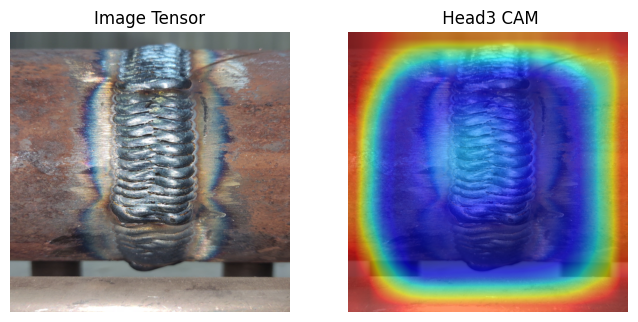

In [ ]:
act_maps_orig = Hook(final_layer_head3)
results = model_project_classic(tensor)
act_maps_orig.remove()

prediction = model_project_classic.predict(img, conf=0.1, iou=0.25, fuse_model=False)
CLASSES = ["adj", "int", "geo", "pro", "non"]
prediction.class_names = CLASSES

labels_predicted_original = prediction.prediction.labels

weights_interested = model_project_classic.heads.head3.cls_pred.weight[2, :].cpu().data.numpy() # извлечение весов
cam = weights_interested.reshape(256).dot(act_maps_orig.features[0].reshape((256, 20*20)))
cam = cam.reshape((20,20))

cam_tensor = torch.from_numpy(cam).float().unsqueeze(0).unsqueeze(0)  # Преобразовываем обратно в тензор
interpol = F.interpolate(cam_tensor, (640, 640), mode="bilinear").squeeze(0).squeeze(0) # Интерполируем карту на изображение

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(tensor.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Image Tensor')


plt.subplot(222)
plt.imshow(tensor.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.imshow(interpol, alpha=0.6, cmap='jet');
plt.title(' Head3 CAM');

In [ ]:
weights_interested.shape

(64, 1, 1)

Усредненные карты тоже не поменялись.

Усредненные карты тоже не поменялись.

In [ ]:
# weights_interested = torch.tensor(model_project_classic.heads.head3.cls_pred.weight[:, :].cpu().data.numpy()) # извлечение весов
# activation_map_batch = torch.tensor(np.expand_dims(act_maps_noisy.features[0], axis=0))


# print(weights_interested.shape, activation_map_batch.shape)
# # Взвешивание карты активации с помощью весов
# # Для каждого класса мы берем вес для каждого канала и суммируем их
# cam = F.conv2d(activation_map_batch, weights_interested)  # Размер (1, 5, 20, 20)

# print(cam.shape)
# # Убираем размерность батча
# cam = cam.squeeze(0)  # Размер (5, 20, 20)
# print(cam.shape)

# # Чтобы получить CAM для каждого класса, нам нужно сделать агрегацию по каналам
# # Применим глобальное усреднение по каждому классу
# cam = cam.mean(dim=(0))  # Среднее по пространственным размерам (H, W)

# plt.imshow(cam)

# **Написание pipeline в N изображений.**

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/data_science/xai_yolo/output_dir/1 (1).jpg'

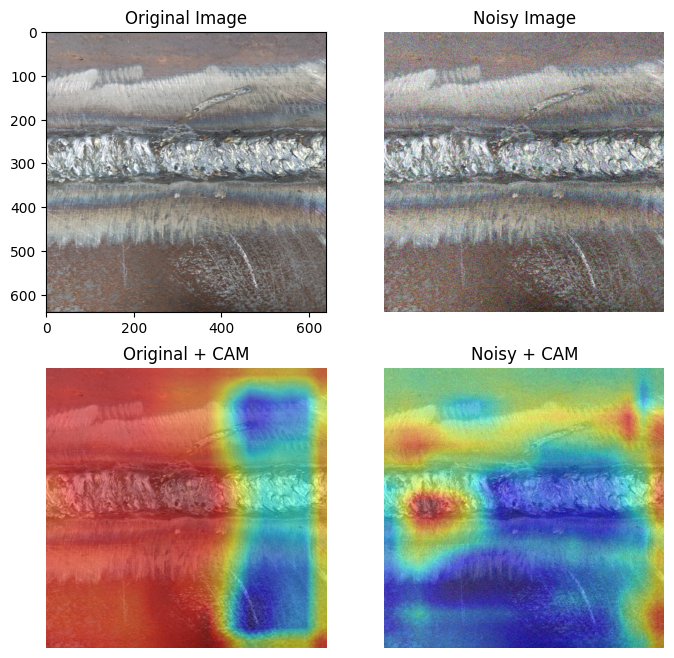

In [ ]:
files = os.listdir('/content/drive/MyDrive/data_science/xai_yolo/dataset')
files = [i for i in files if 'jpg' in i]

path_to_img = '/content/drive/MyDrive/data_science/xai_yolo/dataset/7 (77).jpg'

(img_orig, tensor_orig), (img_noisy, tensor_noisy) = get_original_and_noisy_image(path_to_img, 'gaussian')

act_map_orig, labels_orig = get_map_and_prediction(model_project_classic, img_orig, tensor_orig, 0.1, 0.25)
act_map_noisy, labels_noisy = get_map_and_prediction(model_project_classic, img_noisy, tensor_noisy, 0.1, 0.25)

diff_median = np.median(np.abs(act_map_orig - act_map_noisy)).item()
diff_mean = np.abs(act_map_orig - act_map_noisy).mean().item()

df_row = process_image_predictions(path_to_img, labels_orig, labels_noisy, diff_mean, diff_median)

get_figure(model_project_classic, img_orig, act_map_orig, img_noisy, act_map_noisy, save=True, name='1 (1).jpg', out_dir='/content/drive/MyDrive/data_science/xai_yolo/output_dir/')

In [ ]:
import random
# Устанавливаем фиксированное значение для генератора случайных чисел
random.seed(42)

# Выбираем 300 случайных элементов
files_sample = random.sample(files, 300)


for file in files_sample:

  path_to_img = '/content/drive/MyDrive/data_science/xai_yolo/dataset/'+file
  (img_orig, tensor_orig), (img_noisy, tensor_noisy) = get_original_and_noisy_image(path_to_img)

  act_map_orig, labels_orig = get_map_and_prediction(model_project_classic, img_orig, tensor_orig, 0.1, 0.25)
  act_map_noisy, labels_noisy = get_map_and_prediction(model_project_classic, img_noisy, tensor_noisy, 0.1, 0.25)

  diff_median = np.median(np.abs(act_map_orig - act_map_noisy)).item()
  diff_mean = np.abs(act_map_orig - act_map_noisy).mean().item()

  df_row_to_concat = process_image_predictions(path_to_img, labels_orig, labels_noisy, diff_mean, diff_median)


  df_row = pd.concat([df_row, df_row_to_concat])

  get_figure(model_project_classic, img_orig, act_map_orig, img_noisy, act_map_noisy, save=True, name=file, out_dir='/content/drive/MyDrive/data_science/xai_yolo/output_dir/')


In [ ]:
df_row

In [ ]:
df_row.to_csv('/content/drive/MyDrive/data_science/xai_yolo/results.csv')

In [ ]:
sample = df_row.sample(100)

figure, ax = plt.subplots(figsize=(16, 8))

plt.scatter(sample.index, sample['abs_diff_between_act_mean'], linestyle=':')
plt.scatter(sample.index, sample['abs_diff_between_act_median'], linestyle=':')

ax.xaxis.set_visible(False)

In [ ]:
# # Альтернатива

# import cv2
# import numpy as np
# import supervision as sv
# from supervision.detection.core import Detections
# from typing import Optional, Dict, List

# class Predictions:
#     def __init__(self, detections: Detections, labels: List[str]) -> None:
#         self.detections = detections
#         self.labels = labels

# class YoloNasConfig:
#     CLASSES = ["adj", "int", "geo", "pro", "non"]
#     MODEL_NAME = "yolo_nas_s"
#     WEIGHTS_PATH = "/content/drive/MyDrive/data_science/xai_yolo/surfacing-defects-service/weights/ckpt_best_4.pth"
#     NUM_CLASSES = 5


# class YoloNasModel:

#     def __init__(self, config) -> None:
#         self.config = config if config is not None else YoloNasConfig()
#         device = (
#             torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
#         )
#         self.model = models.get(
#             model_name=self.config.MODEL_NAME,
#             num_classes=self.config.NUM_CLASSES,
#             checkpoint_path=self.config.WEIGHTS_PATH,
#         ).to(device)

#     def predict(self, image: np.ndarray, conf_threshold: float, iou_threshold: float):
#         predictions = self.model.predict(image, conf=conf_threshold, iou=iou_threshold)
#         detections = sv.Detections.from_yolo_nas(predictions)
#         labels = [self.config.CLASSES[i] for i in predictions.prediction.labels]
#         return Predictions(detections=detections, labels=labels)

#     def __call__(self, image: np.ndarray):
#         return self.predict(image)

# # Загрузка модели
# model_project = YoloNasModel(YoloNasConfig)

# model_project.predict(tensor, 0.05, 0.1).labels